In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as py
from sklearn.model_selection import GridSearchCV

**Loading the data set**


In [ ]:
customer_supermarketdf = pd.read_csv('Customer_Behaviour_df.csv', sep=',', index_col=0, decimal=',')

In [ ]:
customer_supermarketdf.shape

(2161, 7)

In [ ]:
customer_supermarketdf.isnull().sum()

I            0
Iu           0
Imax         0
Entropy      0
BasketNum    0
SumExp       0
AvgExp       0
dtype: int64

**Show features' importance as bar chart.**


In [ ]:
def feature_importance(dataframe_cust, classifier_cust):

    importances = classifier_cust.feature_importances_
    features = dataframe_cust.columns

    for feat, importance in zip(features, importances):
        print('{}, importance: {:.2f}'.format(feat, importance))

    py.figure()
    py.title("Feature importances")
    py.bar(x=features, height=importances, align="center")
    py.show()

**Scores and reports**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import statistics
from yellowbrick.classifier import classification_report as cr, confusion_matrix as cm

def report_scores(classifier, test_pred, feat=True, conf_mat=True, report=True):

    # feature importance
    if feat:
        feature_importance(customer_supermarketdf, classifier)
        print('\n')

    # scores
    scores = cross_validate(classifier, train_set, train_label, cv=3, return_train_score= True, scoring='accuracy')

    print('Fit time ', statistics.mean(scores['fit_time']))
    print('Score time ', statistics.mean(scores['score_time']))
    print('Train score ', statistics.mean(scores['train_score']))
    print('Test score ', statistics.mean(scores['test_score']))
    print('\n')

    classes = ['high', 'low', 'medium']

    # confusion matrix
    if conf_mat:
        cm(classifier, train_set, train_label, test_set, test_label,
        classes=classes)

        py.tight_layout()


   # classification report
    if report:
        print(classification_report(test_label, test_pred))
        #cr(classifier, train_set, train_label, test_set, test_label,
          # classes=classes, support=True)

 #       plt.show()

**Defining classification labels**
After sorting the dataset by SumExp, we have splitted it in 3 equal parts.

* **First third** of customers is_low spending
* **Second third** of customers is medium spending
* **Last third** is high spending


In [ ]:
customer_supermarketdf.sort_values(by='SumExp', inplace=True)

l1 = len(customer_supermarketdf)
l2 = l1 // 3
l3 = l2*2
customer_supermarketdf['Label'] = "low"
customer_supermarketdf.loc[customer_supermarketdf.index[l2:l3], 'Label'] = "medium"
customer_supermarketdf.loc[customer_supermarketdf.index[l3:], 'Label'] = "high"

In [ ]:
customer_supermarketdf.tail()

,I,Iu,Imax,Entropy,BasketNum,SumExp,AvgExp,Label
CustomerID,,,,,,,,
13703.0,1,1,1,0.0,1,99.5,99.5,high
12823.0,3,1,1,1.0579054247036734,3,994.5,331.5,high
17019.0,158,114,68,4.709707786947338,3,995.93,331.97666666666663,high
17083.0,34,22,20,3.230738141620585,2,996.02,498.01,high
17238.0,177,137,51,4.931432923969297,6,997.52,166.25333333333333,high


In [ ]:
customer_supermarketdf.shape

(2161, 8)

**We have dropped columns that won't be used in predictive analysis**



In [ ]:
customer_supermarketdf.drop(columns=['Iu', 'Imax', 'SumExp', 'AvgExp'], axis=1, inplace=True)

In [ ]:
customer_supermarketdf.tail()

,I,Entropy,BasketNum,Label
CustomerID,,,,
13703.0,1,0.0,1,high
12823.0,3,1.0579054247036734,3,high
17019.0,158,4.709707786947338,3,high
17083.0,34,3.230738141620585,2,high
17238.0,177,4.931432923969297,6,high


**Splitting Dataset**


In [ ]:
from sklearn.model_selection import train_test_split

label = customer_supermarketdf.pop("Label")
train_set, test_set, train_label, test_label = train_test_split(customer_supermarketdf, label, stratify=label, test_size=0.3, random_state=42)

train_label_cat = train_label.astype('category').cat.codes
test_label_cat = test_label.astype('category').cat.codes

print('Train set size: ', len(train_set))
print('Test set size: ', len(test_set))

Train set size:  1512
Test set size:  649


**Naive Bayes classifier**

Fit time  0.004900614420572917
Score time  0.0029408137003580728
Train score  0.435515873015873
Test score  0.42923280423280424




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


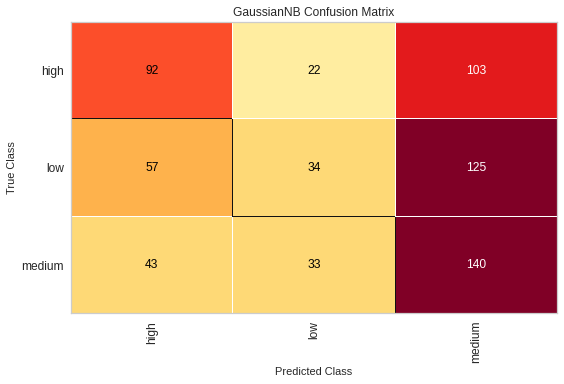

              precision    recall  f1-score   support

        high       0.48      0.42      0.45       217
         low       0.38      0.16      0.22       216
      medium       0.38      0.65      0.48       216

    accuracy                           0.41       649
   macro avg       0.41      0.41      0.38       649
weighted avg       0.41      0.41      0.38       649



<Figure size 576x396 with 0 Axes>

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(train_set, train_label)

test_pred_gnb = gnb.predict(test_set)

report_scores(gnb, test_pred_gnb, feat=False)


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV
dt=DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5,6,7,8,9,10,15,20,30,40,50],
                  'max_features': [1, 2, 3, 4,5,6,7,8,9,10],
                 'random_state':[0, 1, 2, 3, 4, 5, 10, 15,20,35,50,80,100,150,180,200],
                 'criterion':['gini','entropy'],
                 }

grid_search = GridSearchCV(dt, param_grid = parameter_grid,
                          cv =10)

grid_search.fit(train_set, train_label)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))

Best Score: 0.5456082258626699
Best params: {'criterion': 'gini', 'max_depth': 5, 'max_features': 2, 'random_state': 3}


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
33600 fits failed out of a total of 48000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 937, in fit
    super().fit(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py", line 308, in fit
    raise ValueError("max_features must be in (0, n_features]")
ValueError: max_features must be in (0, n_feat

In [ ]:
dt=DecisionTreeClassifier(max_depth=2,criterion='gini',max_features=1,random_state=5)


I, importance: 0.62
Entropy, importance: 0.38
BasketNum, importance: 0.00


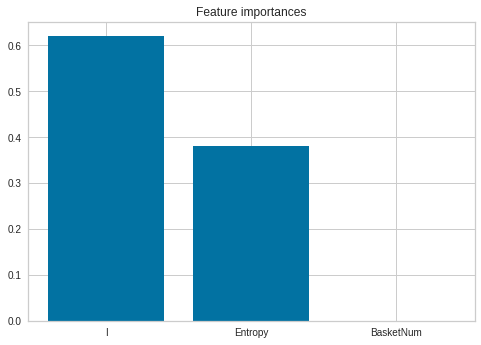



Fit time  0.003948052724202474
Score time  0.002161820729573568
Train score  0.5201719576719577
Test score  0.5125661375661376




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


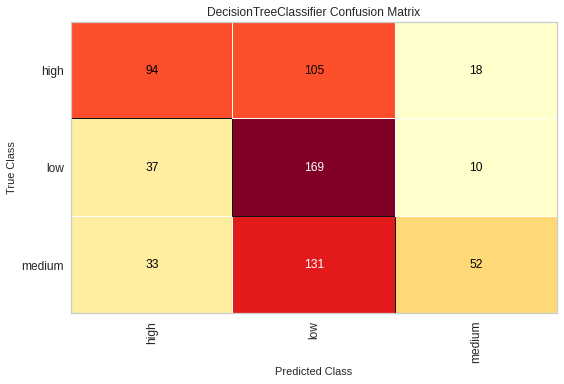

              precision    recall  f1-score   support

        high       0.57      0.43      0.49       217
         low       0.42      0.78      0.54       216
      medium       0.65      0.24      0.35       216

    accuracy                           0.49       649
   macro avg       0.55      0.49      0.46       649
weighted avg       0.55      0.49      0.46       649



<Figure size 576x396 with 0 Axes>

In [ ]:
dt.fit(train_set, train_label)
pred=dt.predict(test_set)
report_scores(dt, pred)

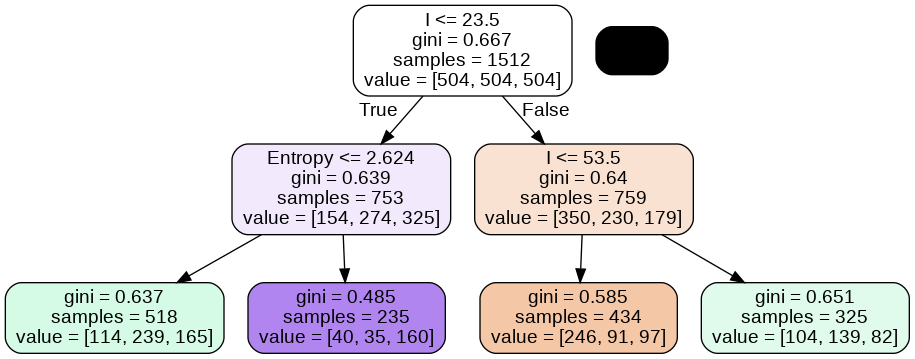

In [ ]:
# visualize the obtained decision tree
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(dt, out_file=None, max_depth=3,
                           feature_names=list(train_set.columns),
                           filled=True, rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

**RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
parameter_grid = {'n_estimators': [300,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [6,7,8,10,12],
    'criterion' :['gini', 'entropy']}
rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, param_grid = parameter_grid,
                          cv =5)

grid_search.fit(train_set, train_label)

print ("Best Score: {}".format(grid_search.best_score_))
print ("Best params: {}".format(grid_search.best_params_))



Best Score: 0.5529145629794768
Best params: {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 300}


I, importance: 0.39
Entropy, importance: 0.46
BasketNum, importance: 0.16


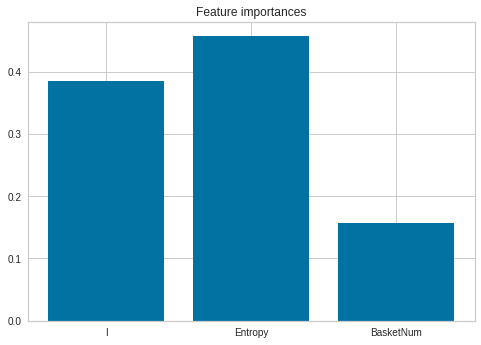



Fit time  1.0634322961171467
Score time  0.0841829776763916
Train score  0.6729497354497355
Test score  0.5396825396825397




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


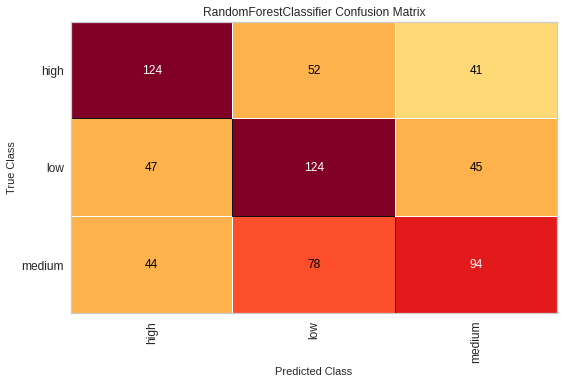

              precision    recall  f1-score   support

        high       0.58      0.57      0.57       217
         low       0.49      0.57      0.53       216
      medium       0.52      0.44      0.47       216

    accuracy                           0.53       649
   macro avg       0.53      0.53      0.53       649
weighted avg       0.53      0.53      0.53       649



<Figure size 576x396 with 0 Axes>

In [ ]:
rf=RandomForestClassifier(random_state=42, max_features='log2', n_estimators= 500, max_depth=6, criterion='entropy')

rf = rf.fit(train_set, train_label)

test_pred_rf = rf.predict(test_set)

report_scores(rf, test_pred_rf)

**KNN Classifier**

Text(0, 0.5, 'Error Rate')

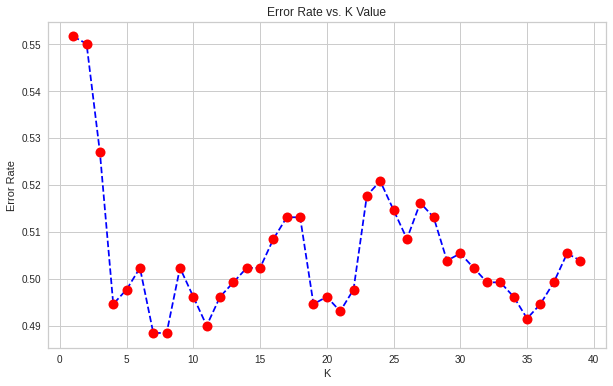

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

error_rate = []
max_i = 40
for i in range(1,max_i):

    knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto')
    knn = knn.fit(train_set, train_label)
    pred_i = knn.predict(test_set)
    error_rate.append(np.mean(pred_i != test_label))

py.figure(figsize=(10,6))
py.plot(range(1,max_i), error_rate, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
py.title('Error Rate vs. K Value')
py.xlabel('K')
py.ylabel('Error Rate')

Fit time  0.004235029220581055
Score time  0.015956878662109375
Train score  0.5846560846560847
Test score  0.5211640211640212




/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


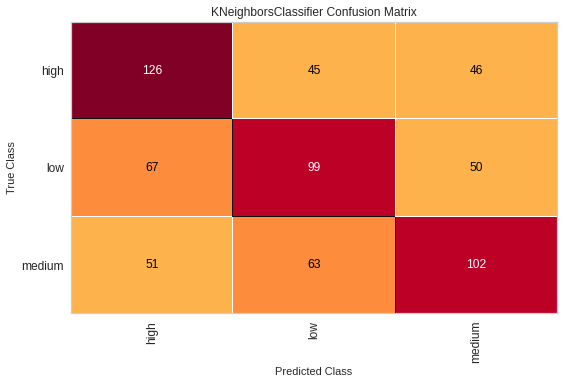

              precision    recall  f1-score   support

        high       0.52      0.58      0.55       217
         low       0.48      0.46      0.47       216
      medium       0.52      0.47      0.49       216

    accuracy                           0.50       649
   macro avg       0.50      0.50      0.50       649
weighted avg       0.50      0.50      0.50       649



<Figure size 576x396 with 0 Axes>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=12, algorithm='auto')

knn = knn.fit(train_set, train_label)

test_pred_knn = knn.predict(test_set)

report_scores(knn, test_pred_knn, feat=False)


**SVM Classifier**

In [ ]:
'''from sklearn.svm import SVC

svm = SVC()

svm = svm.fit(train_set, train_label)

test_pred_svm = svm.predict(test_set)

report_scores(svm, test_pred_svm, feat=False)
'''

'from sklearn.svm import SVC\n\nsvm = SVC()\n\nsvm = svm.fit(train_set, train_label)\n\ntest_pred_svm = svm.predict(test_set)\n\nreport_scores(svm, test_pred_svm, feat=False)\n'

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(train_set, train_label)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.446 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.531 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.483 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.457 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.546 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.432 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.548 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.497 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.454 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.566 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.446 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [ ]:
grid_predictions = grid.predict(test_set)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.490 total time=   0.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.490 total time=   0.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.480 total time=   0.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.483 total time=   0.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.532 total time=   0.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.495 total time=   0.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.495 total time=   0.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.490 total time=   0.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.478 total time=   0.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.547 total time=   0.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.1s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


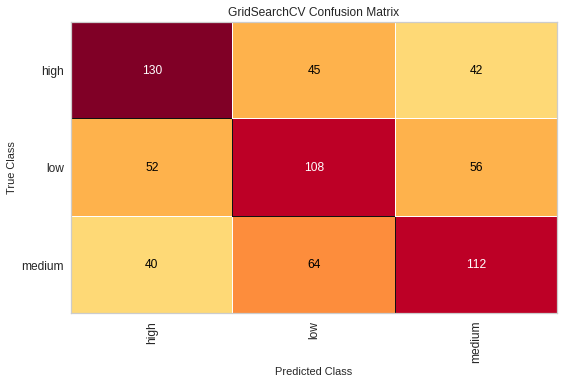

              precision    recall  f1-score   support

        high       0.59      0.60      0.59       217
         low       0.50      0.50      0.50       216
      medium       0.53      0.52      0.53       216

    accuracy                           0.54       649
   macro avg       0.54      0.54      0.54       649
weighted avg       0.54      0.54      0.54       649



<Figure size 576x396 with 0 Axes>

In [ ]:
report_scores(grid, grid_predictions, feat=False)
